# Clustering data using Ckmeans.1d.dp

Illustrates how to do the clustering using the library ckmeans.

After the cluster created, we can calculate the mean and stddev of each one, creating the corresponding normal distributions.

In [8]:
seed=42
quantreg_tau=0.05
df_str=""
metric=""
coeff_col_name=""
output_file="/tmp/ckmeans.csv"

In [10]:
library(Ckmeans.1d.dp)
library(quantreg)

set.seed(seed) #forcing seed for reproductibility

## Reading dataframe

In [132]:
df = read.csv(text=df_str)
print(summary(df))
head(df)

       X               op               msg_size     start        
 Min.   :  1130   Length:3500        Min.   :1   Min.   : 0.2003  
 1st Qu.: 82565   Class :character   1st Qu.:2   1st Qu.:14.3932  
 Median :179094   Mode  :character   Median :4   Median :30.8789  
 Mean   :174237                      Mean   :4   Mean   :30.3998  
 3rd Qu.:262094                      3rd Qu.:6   3rd Qu.:45.7296  
 Max.   :358579                      Max.   :7   Max.   :63.0828  
    duration          experiment            type               index       
 Min.   :1.510e-07   Length:3500        Length:3500        Min.   :  2260  
 1st Qu.:1.560e-07   Class :character   Class :character   1st Qu.:165130  
 Median :1.580e-07   Mode  :character   Mode  :character   Median :358189  
 Mean   :2.322e-07                                         Mean   :348475  
 3rd Qu.:2.270e-07                                         3rd Qu.:524188  
 Max.   :1.452e-05                                         Max.   :717158  

,X,op,msg_size,start,duration,experiment,type,index
,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>
1,1130,MPI_Send,3,0.200334,2.57e-07,grenoble,exp/exp_PingPong.csv,2260
2,1131,MPI_Send,3,0.200338,1.85e-07,grenoble,exp/exp_PingPong.csv,2262
3,1132,MPI_Send,3,0.200342,1.63e-07,grenoble,exp/exp_PingPong.csv,2264
4,1133,MPI_Send,3,0.200345,1.56e-07,grenoble,exp/exp_PingPong.csv,2266
5,1134,MPI_Send,3,0.200349,1.54e-07,grenoble,exp/exp_PingPong.csv,2268
6,1135,MPI_Send,3,0.200352,1.64e-07,grenoble,exp/exp_PingPong.csv,2270


## Quantile regression

Use quantile regression to get the lowest points in the duration graph.

This is important to avoid having negative intercept which could lead to negative duration depending on the message size.

In [13]:
formula = paste0(metric, "~", coeff_col_name)
rqResult = rq(formula=formula, data=df, tau=quantreg_tau)
rqResult

Call:
rq(formula = formula, tau = quantreg_tau, data = df)

Coefficients:
 (Intercept)     msg_size 
1.526667e-07 3.333333e-10 

Degrees of freedom: 3500 total; 3498 residual

## Clustering

Calculating the intercept for the duration of each message considering the quantile regression.

In [136]:
df$intercept_estimate = df[[metric]] - df[[coeff_col_name]]*coef(rqResult)[coeff_col_name]

Running ckmeans to identify clusters.

In [138]:
ckmeans = Ckmeans.1d.dp(df$intercept_estimate)
df$cluster = ckmeans$cluster
ckmeans$centers

Warning message in cluster.1d.dp(x, k, y, method, estimate.k, "L2", deparse(substitute(x)), :
“Max number of clusters used. Consider increasing k!
”


[1] 1.559763e-07 1.916024e-07 2.309763e-07 2.793051e-07 4.375881e-07
[6] 5.104603e-07 5.937901e-07 7.054843e-07 1.451800e-05

Calculating mean and standard deviation for each cluster. Remove NA rows if necessary

In [140]:
library(dplyr)

df_normal = df %>% group_by(cluster) %>% summarize(mean = mean(intercept_estimate), sd = sd(intercept_estimate), count = n())
df_normal = na.omit(df_normal)
df_normal

cluster,mean,sd,count
<int>,<dbl>,<dbl>,<int>
1,1.559763e-07,4.078012e-09,2166
2,1.916024e-07,1.094938e-08,368
3,2.309763e-07,1.245767e-08,211
4,2.793051e-07,2.045145e-08,130
5,4.375881e-07,1.105646e-08,454
6,5.104603e-07,2.172848e-08,63
7,5.937901e-07,2.779261e-08,54
8,7.054843e-07,4.410606e-08,53


Calculating probability and adding the quantile regression

In [143]:
df_normal$coefficient = coef(rqResult)[coeff_col_name]
df_normal$prob = df_normal$count/sum(df_normal$count)

cluster,mean,sd,count,coefficient,prob
<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,1.559763e-07,4.078012e-09,2166,3.333333e-10,0.61903401
2,1.916024e-07,1.094938e-08,368,3.333333e-10,0.10517291
3,2.309763e-07,1.245767e-08,211,3.333333e-10,0.06030294
4,2.793051e-07,2.045145e-08,130,3.333333e-10,0.03715347
5,4.375881e-07,1.105646e-08,454,3.333333e-10,0.12975136
6,5.104603e-07,2.172848e-08,63,3.333333e-10,0.01800514
7,5.937901e-07,2.779261e-08,54,3.333333e-10,0.01543298
8,7.054843e-07,4.410606e-08,53,3.333333e-10,0.01514718


Saving result to a csv file.

In [ ]:
df_normal %>% select(mean, sd, prob, coefficient) %>% write.csv(output_file)

## Visualizing

Histogram with vertical lines at the mean of each cluster.

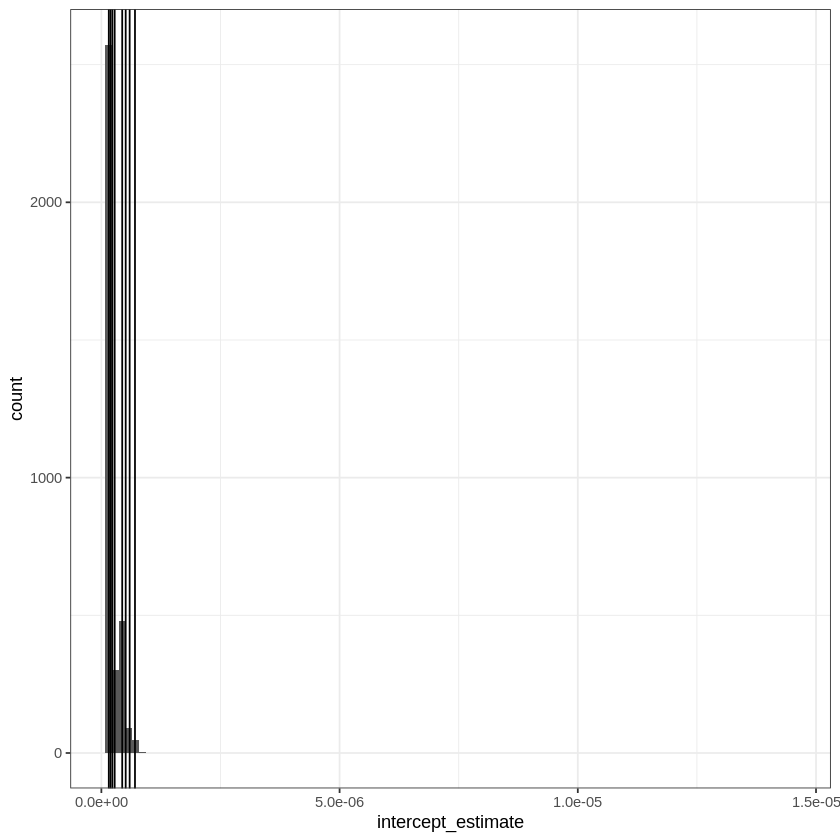

In [47]:
library(ggplot2)

ggplot(df, aes(x=intercept_estimate)) + geom_histogram(bins=100) +
    geom_vline(data=df_normal, aes(xintercept=mean)) + 
    theme_bw()

Same but in log scale

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 62 rows containing missing values (geom_bar).”


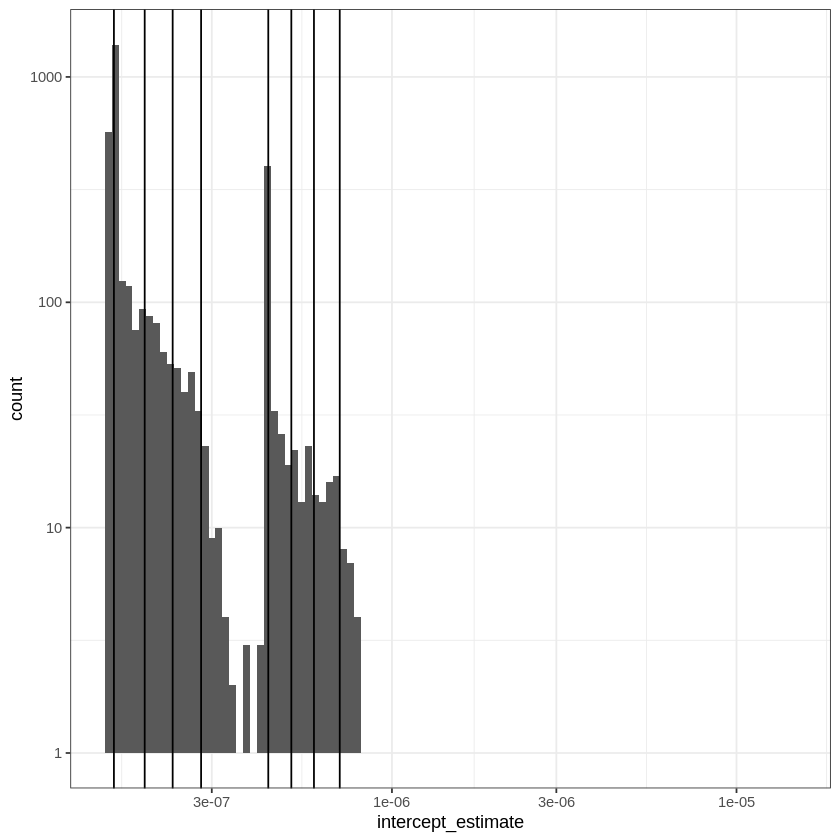

In [48]:
ggplot(df, aes(x=intercept_estimate)) + geom_histogram(bins=100) +
    geom_vline(data=df_normal, aes(xintercept=mean)) + 
    scale_x_log10() + scale_y_log10() +
    theme_bw()

Plot original data with colors.

Each color represents a group found by ckmeans. The line is the mean value for each group.

Also plot an extra line with the result of the quantile regression.

Joining, by = "cluster"

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


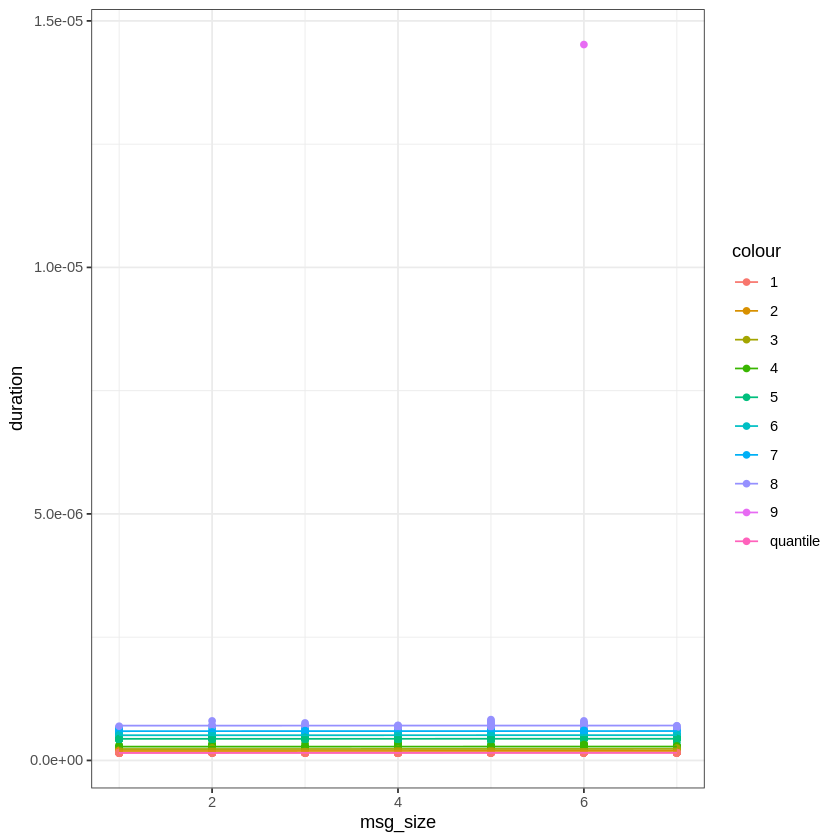

In [130]:
# new dataframe where duration(y) is equal to estimated values by group
tmp = data.frame(cluster=df$cluster, x=df[[coeff_col_name]], y=df[[coeff_col_name]]*coef(rqResult)[coeff_col_name])
tmp = tmp %>% left_join(df_normal) %>% mutate(y = y + mean) %>% select(cluster, x, y)#sum by estimated intercept
# add quantile regression to it
tmp = rbind(tmp, data.frame(cluster="quantile", x=df[[coeff_col_name]], y=df[[coeff_col_name]]*coef(rqResult)[coeff_col_name] + coef(rqResult)['(Intercept)']))

ggplot(df, aes_string(x=coeff_col_name, y=metric, color=as.factor(df$cluster))) + geom_point() +
    geom_line(data=tmp, aes(x=x, y=y, color=cluster)) +
    theme_bw()

Same in log scale in y-axis.

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


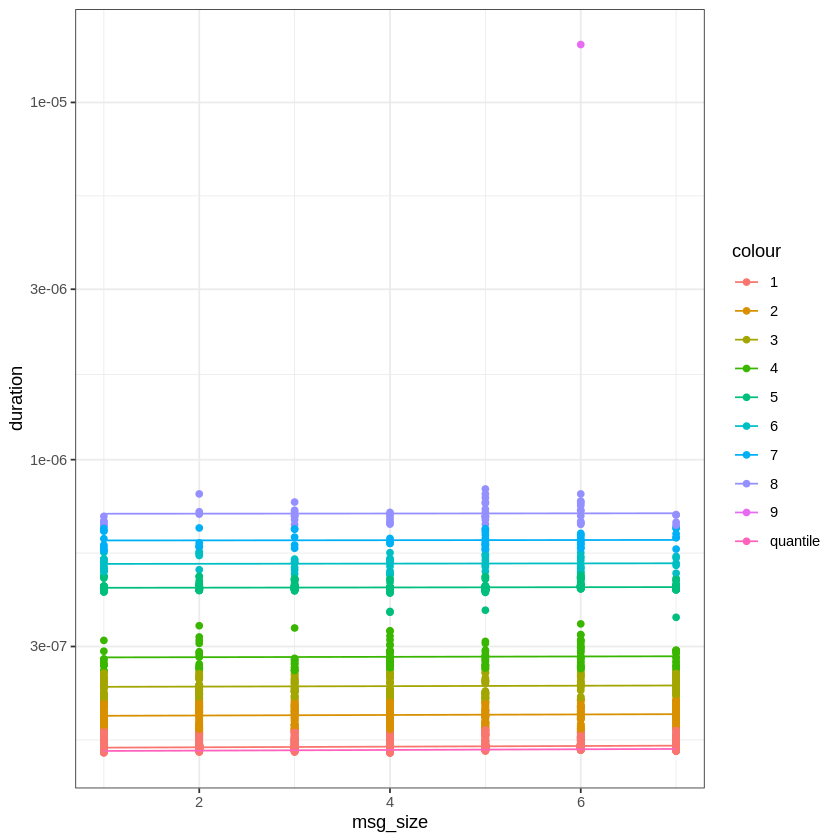

In [131]:
ggplot(df, aes_string(x=coeff_col_name, y=metric, color=as.factor(df$cluster))) + geom_point() +
    geom_line(data=tmp, aes(x=x, y=y, color=as.factor(cluster))) +
    scale_y_log10() +
    theme_bw()
ggsave(paste0('plot_ckmeans_', unique(df$op), '.png'))